In [1]:
import pandas as pd
df = pd.read_csv("../00_data/Feature_Built_Sent_Data_22MAR.gz")

In [2]:
df

,Unnamed: 0,Date,videoTitleSentimentScore_pos,videoTitleSentimentScore_neg,captionSentimentScore_pos,captionSentimentScore_neg,num_days_since_pub,viewcounts_weighted,like_count_weighted,like_dislike_ratio,weighted_like_dislike_ratio,like_dislike_ratio_by_viewcounts_weighted,index,percent_change,action,_merge
0,0,2020-10-02,0.081317,0.099751,0.102556,0.036249,17.925926,71814.282680,3271.401019,0.969752,0.969752,69921.826086,2020-10-02,0.044362,buy,both
1,1,2020-10-03,0.059800,0.065880,0.116100,0.034660,35.600000,71921.099664,3523.220911,0.969585,0.969585,70150.404005,2020-10-03,0.041791,buy,both
2,2,2020-10-04,0.066000,0.059480,0.110600,0.035320,21.680000,66084.953130,3030.285674,0.972772,0.972772,64444.365869,2020-10-04,0.022541,hold,both
3,3,2020-10-05,0.071018,0.065469,0.110771,0.031495,19.829091,61208.718514,3150.355807,0.971021,0.971021,59725.066775,2020-10-05,0.013192,hold,both
4,4,2020-10-06,0.066353,0.069018,0.110309,0.031280,19.432727,72276.063635,3948.601316,0.972598,0.972598,70807.388299,2020-10-06,-0.022469,hold,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,113,2021-03-15,0.037338,0.033960,0.087764,0.030724,109.768889,15241.801392,1049.344298,0.955442,0.955442,14861.456219,2021-03-15,-0.021599,hold,both
114,114,2021-03-16,0.037245,0.064280,0.105100,0.034100,108.970000,14870.723784,1032.050839,0.954523,0.954523,14469.862263,2021-03-16,-0.043737,sell,both
115,115,2021-03-17,0.038080,0.066406,0.102891,0.033063,111.137143,14748.626569,939.470945,0.956001,0.956001,14378.400682,2021-03-17,-0.006551,hold,both
116,116,2021-03-18,0.051550,0.061970,0.099855,0.031660,107.740000,15558.251680,1049.395704,0.956913,0.956913,15162.712790,NaN,NaN,NaN,left_only


In [3]:
df = df.drop(['Unnamed: 0','index','_merge'],axis=1)

In [8]:
df = df.dropna()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 115
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Date                                       116 non-null    object 
 1   videoTitleSentimentScore_pos               116 non-null    float64
 2   videoTitleSentimentScore_neg               116 non-null    float64
 3   captionSentimentScore_pos                  116 non-null    float64
 4   captionSentimentScore_neg                  116 non-null    float64
 5   num_days_since_pub                         116 non-null    float64
 6   viewcounts_weighted                        116 non-null    float64
 7   like_count_weighted                        116 non-null    float64
 8   like_dislike_ratio                         116 non-null    float64
 9   weighted_like_dislike_ratio                116 non-null    float64
 10  like_dislike_ratio_by_view

In [10]:
df

,Date,videoTitleSentimentScore_pos,videoTitleSentimentScore_neg,captionSentimentScore_pos,captionSentimentScore_neg,num_days_since_pub,viewcounts_weighted,like_count_weighted,like_dislike_ratio,weighted_like_dislike_ratio,like_dislike_ratio_by_viewcounts_weighted,percent_change,action
0,2020-10-02,0.081317,0.099751,0.102556,0.036249,17.925926,71814.282680,3271.401019,0.969752,0.969752,69921.826086,0.044362,buy
1,2020-10-03,0.059800,0.065880,0.116100,0.034660,35.600000,71921.099664,3523.220911,0.969585,0.969585,70150.404005,0.041791,buy
2,2020-10-04,0.066000,0.059480,0.110600,0.035320,21.680000,66084.953130,3030.285674,0.972772,0.972772,64444.365869,0.022541,hold
3,2020-10-05,0.071018,0.065469,0.110771,0.031495,19.829091,61208.718514,3150.355807,0.971021,0.971021,59725.066775,0.013192,hold
4,2020-10-06,0.066353,0.069018,0.110309,0.031280,19.432727,72276.063635,3948.601316,0.972598,0.972598,70807.388299,-0.022469,hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,2021-03-13,0.048660,0.046560,0.103400,0.036880,103.340000,18471.992887,1188.835967,0.954353,0.954353,17957.742937,0.022908,hold
112,2021-03-14,0.042000,0.030040,0.099380,0.035100,108.420000,18673.335915,1167.509207,0.958063,0.958063,18250.808819,0.002541,hold
113,2021-03-15,0.037338,0.033960,0.087764,0.030724,109.768889,15241.801392,1049.344298,0.955442,0.955442,14861.456219,-0.021599,hold
114,2021-03-16,0.037245,0.064280,0.105100,0.034100,108.970000,14870.723784,1032.050839,0.954523,0.954523,14469.862263,-0.043737,sell


# EDA

    - Scaling Problem. captionSentimentScore_neg really small

<AxesSubplot:xlabel='videoTitleSentimentScore_pos', ylabel='Count'>

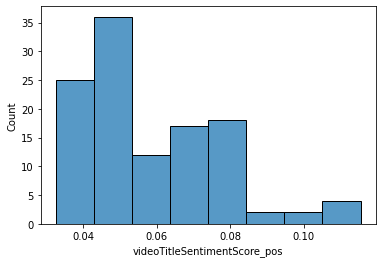

In [44]:
import seaborn as sns
sns.histplot(df,x='videoTitleSentimentScore_pos')

<AxesSubplot:xlabel='videoTitleSentimentScore_neg', ylabel='Count'>

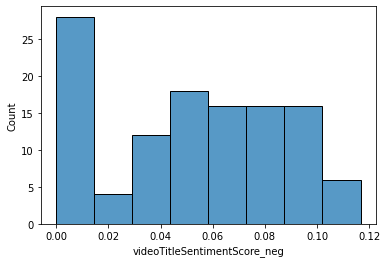

In [45]:
sns.histplot(df,x='videoTitleSentimentScore_neg')

<AxesSubplot:xlabel='captionSentimentScore_pos', ylabel='Count'>

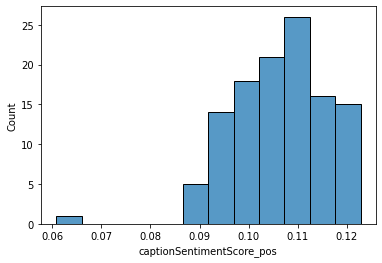

In [46]:
sns.histplot(df,x='captionSentimentScore_pos')

<AxesSubplot:xlabel='captionSentimentScore_neg', ylabel='Count'>

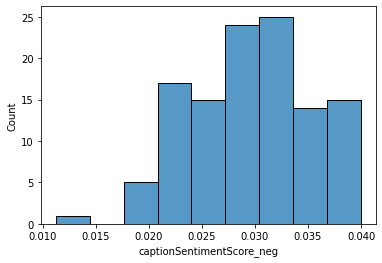

In [47]:
sns.histplot(df,x='captionSentimentScore_neg')

<AxesSubplot:xlabel='num_days_since_pub', ylabel='Count'>

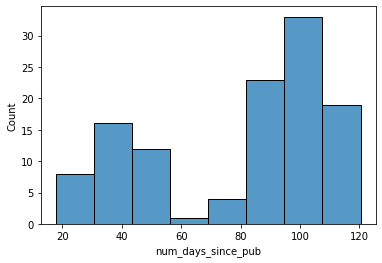

In [48]:
sns.histplot(df,x='num_days_since_pub')

<AxesSubplot:xlabel='action', ylabel='Count'>

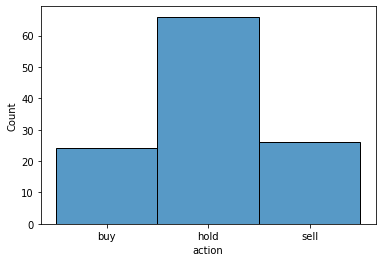

In [49]:
sns.histplot(df,x='action')

# Data Scaling

In [21]:
X = df.iloc[:, 1:11].values
y = df.iloc[:, 12].astype('category').cat.codes.values

In [22]:
y

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 2, 1], dtype=int8)

# One hot encoding --- skip for now
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
y = enc.fit_transform(y.reshape(-1,1)).toarray()

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [14]:
from sklearn.ensemble import RandomForestClassifier

regressor = RandomForestClassifier(n_estimators=10, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [15]:
y_pred

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 1, 0, 2, 1, 1, 1, 1, 1,
       2, 0], dtype=int8)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 1  2  0]
 [ 2 10  1]
 [ 1  4  3]]
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.62      0.77      0.69        13
           2       0.75      0.38      0.50         8

    accuracy                           0.58        24
   macro avg       0.54      0.49      0.49        24
weighted avg       0.62      0.58      0.58        24

0.5833333333333334


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Import some data to play with
iris = datasets.load_iris()

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=10, random_state=0))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

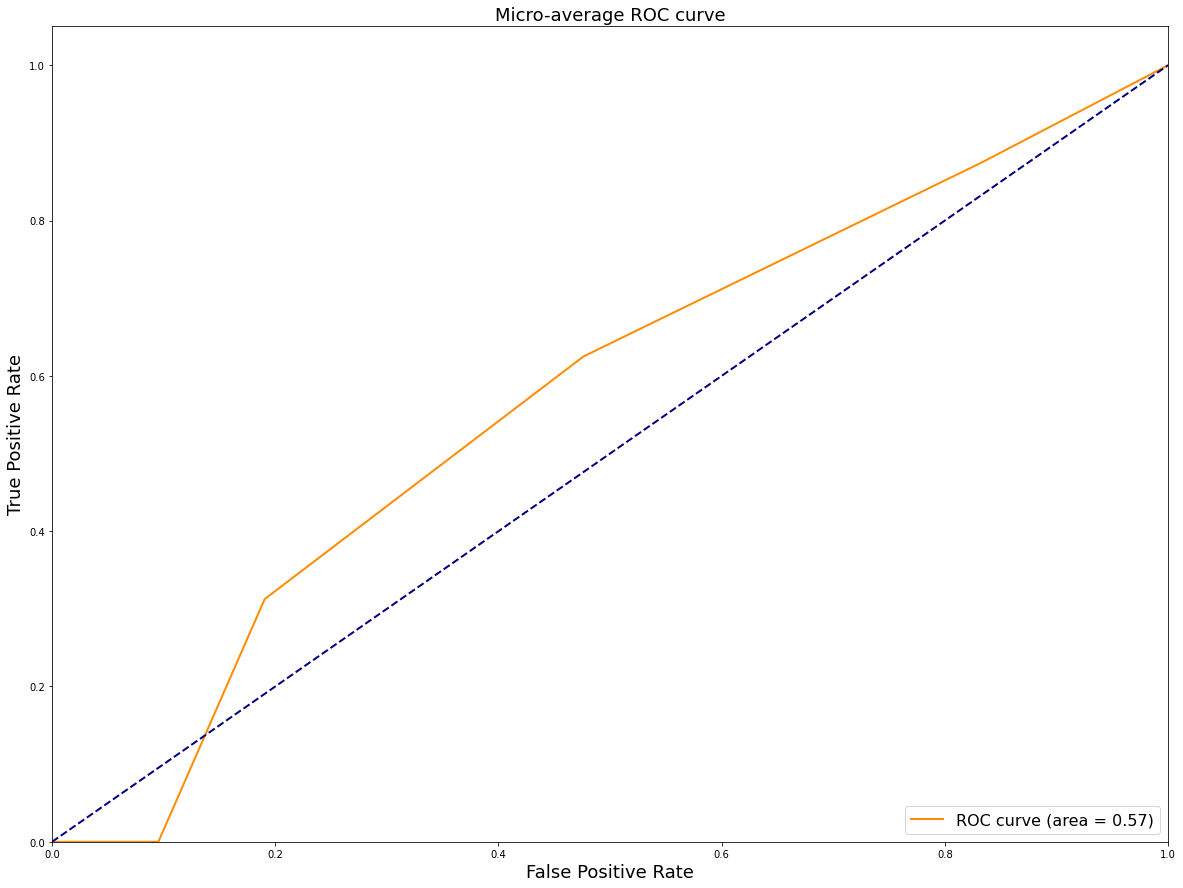

In [42]:
plt.figure(figsize=(20,15))
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize =18)
plt.title('Micro-average ROC curve',fontsize = 18)
plt.legend(loc="lower right",prop={'size': 16})
plt.show()


/Users/mymacbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


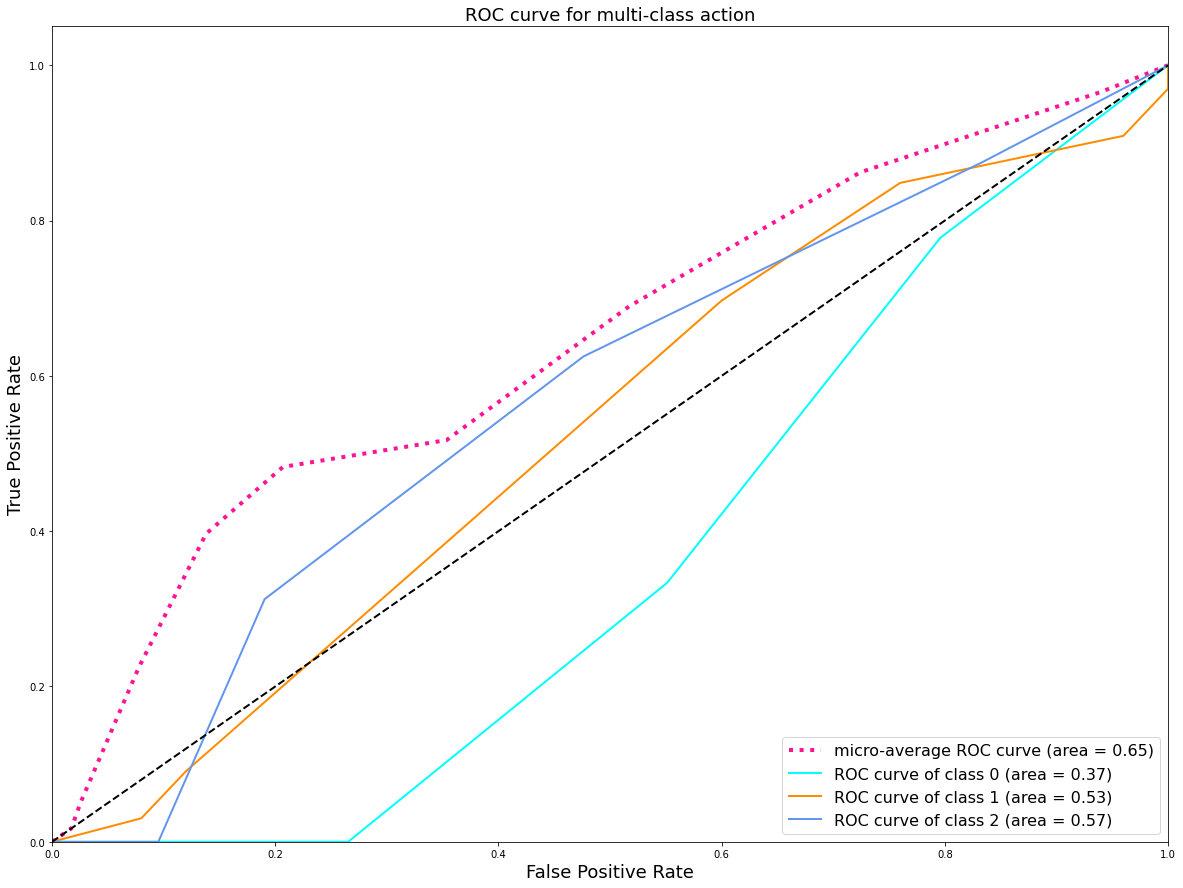

In [50]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20,15))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('ROC curve for multi-class action',fontsize=18)
plt.legend(loc="lower right",prop={'size': 16})
plt.show()


In [25]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.47


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.47')

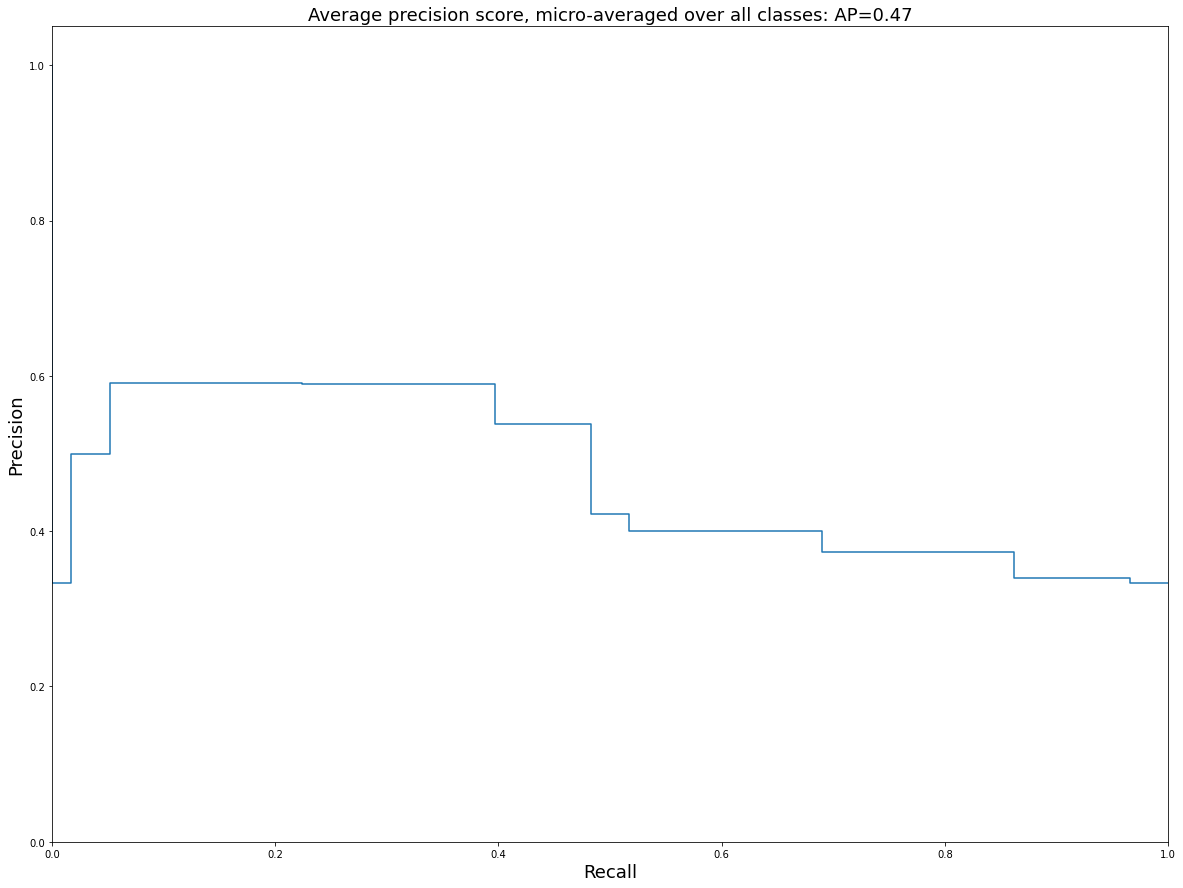

In [40]:
plt.figure(figsize=(20,15))
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall',fontsize=18)
plt.ylabel('Precision',fontsize =18)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]),fontsize=18)

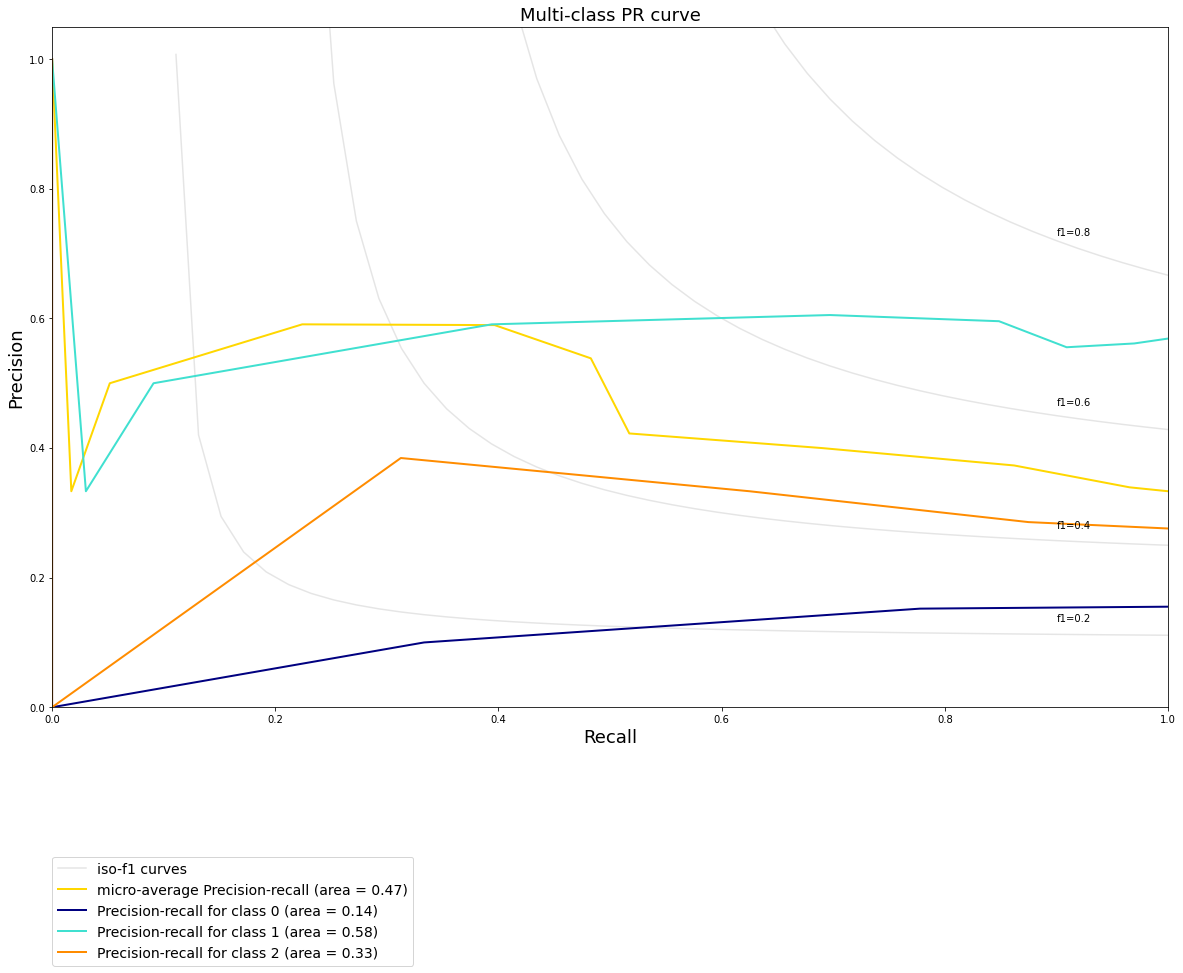

In [53]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(20, 15))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize=18)
plt.ylabel('Precision',fontsize=18)
plt.title('Multi-class PR curve',fontsize=18)
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()